In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm
import numpy as np
import pandas as pd 
import os
from PIL import Image 
from sklearn.model_selection import train_test_split

# !pip install matplotlib
import matplotlib.pyplot as plt 

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
torch.set_num_threads(os.cpu_count())

cuda:0


In [3]:
# Custom Dataset class modeled after Pytorch dataset. Created to avoid 'class-per-folder' 
# organization that is required by standard pytorch datasets.

class DogBreedDataset(Dataset):
    # __init__ receives a pandas dataframe of form ('id')('breed'), a directory
    # containing images, a dict of the form ('breed')(int label), and an optional
    # transform pipeline. 
    def __init__(self, label_df, img_dir, labels, transform=None): 
        self.labels_df = label_df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        self.classes = labels

    # __len__ simply returns the number of samples in a dataset
    def __len__(self): 
        return len(self.labels_df)
    
    # __getitem__ takes in an index representing an entry in the dataset, it returns the img 
    # and proper class label associated with that index 
    def __getitem__(self, index): 
        row = self.labels_df.iloc[index]
        path = os.path.join(self.img_dir, row["id"]+ ".jpg")
        img = Image.open(path)
        img = img.convert("RGB")

        if self.transform: 
            img = self.transform(img)

        label = self.classes[row['breed']]

        return img, label

In [4]:
labels = pd.read_csv("data/labels.csv")
breeds = labels['breed'].unique() 

# Dict mapping 'breed' to index, model will operate on integers and we will convert back to breeds 
classes = {b: i for i, b in enumerate(breeds)}

In [5]:
train_transforms = transforms.Compose([
    transforms.Resize((224,224)), # pytorch expects 224x224 sized images

    # These transformations are standard for introducing more randomness into the training set. 
    # These transformations haven't been tested and perfected individually, but instead
    # come as standard recommended parts of the pipeline for reducing overfitting and promoting
    # generalization 
    transforms.RandomHorizontalFlip(), 
    transforms.RandomResizedCrop(224, scale = (0.8, 1.0)),
    transforms.RandomRotation(15), 
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3), 
    transforms.ToTensor(), 

    # Here we normalize RGB values to the mean and standard deviation of the custom dataset, 
    # the set that our pretrained model was trained on. 
    transforms.Normalize([-0.182, -0.167, -0.191],
                         [1.027, 1.023, 0.986])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # pytorch expects 224x224 sized images
    transforms.ToTensor(),

    # Here we normalize RGB values to the mean and standard deviation for the custom dataset, 
    # the set that our pretrained model was trained on. 
    transforms.Normalize([-0.182, -0.167, -0.191],
                         [1.027, 1.023, 0.986])
])

In [6]:
dataset = DogBreedDataset(labels, "data/train", classes, train_transforms)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [7]:
num_classes = len(dataset.classes)

In [8]:
train_df, val_df = train_test_split(dataset.labels_df, 
                                    test_size=0.2, 
                                    stratify=dataset.labels_df['breed'])

train_df.to_csv("train_split.csv", index=False)
val_df.to_csv("val_split.csv", index=False)

In [9]:
train_dataset = DogBreedDataset(
    label_df=train_df,
    img_dir ='data/train',
    labels = classes,
    transform=train_transforms
)

val_dataset = DogBreedDataset(
    label_df = val_df,
    img_dir ='data/train',
    labels = classes, 
    transform=val_transforms
)

In [10]:
train_loader = DataLoader(
    # these variable primarily affect efficiency at fetching data
    train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=8, # when running on windows num_worker must equal zero, there is a well known pytorch bug forcing this 
    pin_memory=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=8,
    pin_memory=False
)


In [11]:
import torch
from torch.utils.data import DataLoader
import numpy as np

def calculate_normalization_stats(dataloader):
    """Calculate mean and std for each channel in the dataset"""
    channels = 3
    mean = torch.zeros(channels)
    std = torch.zeros(channels)
    num_samples = 0
    
    for images, _ in dataloader:
        # Rearrange batch to be (channels, pixels)
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        num_samples += batch_samples
    
    mean /= num_samples
    std /= num_samples
    
    return mean.tolist(), std.tolist()

# Calculate for your training data
# train_loader = DataLoader(your_train_dataset, batch_size=64, shuffle=False)
your_mean, your_std = calculate_normalization_stats(train_loader)
print(f"Your dataset - Mean: {your_mean}, Std: {your_std}")

Your dataset - Mean: [0.6098415851593018, 0.5730670690536499, 0.5630524754524231], Std: [0.2291700392961502, 0.22405126690864563, 0.22475649416446686]


In [12]:
for i in range(3):
    try:
        x, y = train_dataset[i]
        print(f"Item {i}: Image shape = {x.shape}, Label = {y}")
    except Exception as e:
        print(f"Error at index {i}: {e}")


Item 0: Image shape = torch.Size([3, 224, 224]), Label = 33
Item 1: Image shape = torch.Size([3, 224, 224]), Label = 2
Item 2: Image shape = torch.Size([3, 224, 224]), Label = 58


In [13]:
# device  = "mps" # using mps on my macbook

# This line represents our model. For this implementation we are 
# using resnet18 with weights from scratch
cnn = models.resnet18(weights=None)

# Here we freeze all but the last layer of the cnn, this lets us
# start from a good place for image classification but lets us
# design our own final layer for predictions. 
for param in cnn.parameters(): 
    param.requires_grad = False

# Our final layer. This resembles a 2 layer MLP (multi layer perceptron)
# That maps the hundreds or thousands of features present in the CNN 
# to the 120 outputs that we need to map to class probabilities. This layer is 
# the only layer we are training in our training loop. 
cnn.fc = nn.Sequential(
    nn.Linear(cnn.fc.in_features, 512), 
    nn.ReLU(), 
    nn.Dropout(0.5), # Using dropout will hurt training performance, but decrease overfitting 
    nn.Linear(512, num_classes)
)

cnn=cnn.to(device)
print(cnn)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
criterion = nn.CrossEntropyLoss() # we'll be using CrossEntropy loss 
# This is our optimizer, ADAM is similar to an improved verison of stochastic 
# gradient descent designed specifically for deep learning
optimizer = optim.Adam(cnn.fc.parameters(), lr=1e-3, weight_decay=1e-4) 

In [15]:
# TRAINING LOOP 

# BLAME: Zebulon Mcknight ***

# Our training function takes in a reference to our model, our training and validation
# loaders, a loss function, an optimizer, and a number of epochs to train for 
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs): 
    train_losses =[]
    val_losses =[]
    final_train_acc= 0
    final_val_acc = 0
    for epoch in range(num_epochs): 
        model.train()

        # We will track loss and accuracy for each epoch 
        running_loss = 0.0
        running_corrects = 0
        

        # each epoch is broken into batches of 64 images
        for inputs, labels in tqdm(train_loader): 
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs,1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += (preds == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        final_train_acc= epoch_acc
        
        # print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_loss} | Accuracy: {epoch_acc}")

        # Validation loop
        # BLAME: Kyle Bomar ***
         
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        with torch.no_grad(): 
            for inputs, labels in val_loader: 
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += (preds == labels).sum().item()
        
        val_loss /= len(val_loader.dataset)
        val_acc = val_corrects / len(val_loader.dataset)
        val_losses.append(val_loss)
        final_val_acc = val_acc
        # print(f"Validation Loss: {val_loss} | Accuracy: {val_acc}")

    plt.figure(figsize=(8, 4))
    plt.plot(np.arange(num_epochs), train_losses, 'o--b', label='Training Loss',)
    plt.plot(np.arange(num_epochs), val_losses, 'o--r', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('MLP Model Training and Validation Losses')
    plt.show()
    
    print("Training finished.")
    print(f"Final Training Accuracy: {final_train_acc}")
    print(f"Final Validation Accuracy: {final_val_acc}")


100%|█████████████████████████████████████████████████████████████████████| 128/128 [00:10<00:00, 12.20it/s]


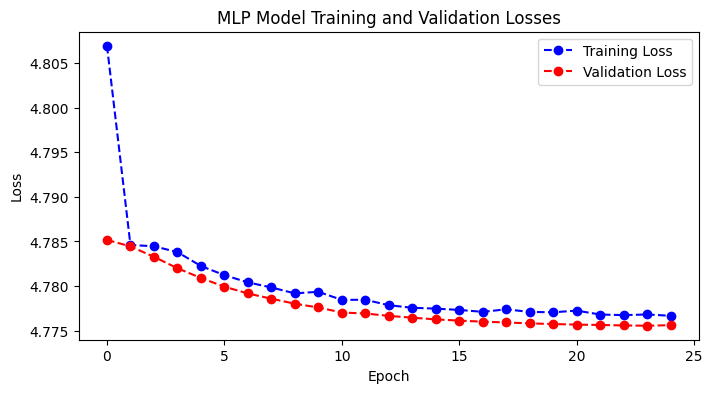

Training finished.
Final Training Accuracy: 0.012351718234071175
Final Validation Accuracy: 0.012224938875305624


In [16]:
train(cnn, train_loader, val_loader, criterion, optimizer, num_epochs=25)


In [17]:
model_state = cnn.state_dict()

torch.save(model_state, "from_scratch_resnet.pth")